In [324]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten

from tensorflow.keras.optimizers import Adam

plt.rcParams["figure.figsize"] = (10,6)

In [325]:
# read data (Date already cast to datetime with "parse_dates")

data_directory = "data/"

df = pd.read_csv(data_directory + 'train.csv', parse_dates=['Date']).set_index('Date')
df.head(25)

,Open,High,Low,Close,Adj Close,Volume,Target
Date,,,,,,,
1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0
1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1
1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1
1994-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0
1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1
1994-01-10,3655.199951,3678.199951,3655.199951,3660.600098,3660.596436,0.0,1
1994-01-11,3679.699951,3712.500000,3679.699951,3712.399902,3712.396240,0.0,1
1994-01-12,3712.300049,3712.300049,3675.899902,3680.100098,3680.096436,0.0,1
1994-01-13,3680.100098,3698.199951,3670.399902,3680.800049,3680.796387,0.0,1


In [326]:
# we see that where a row has any null, the target is always 0...

print("Unique target values on null data:", df[df.isnull().any(axis=1)]['Target'].unique())

# It seems like by now the best option is to drop the empty rows

df = df.dropna()
print(df.info())
print(df.describe())
df.head()

Unique target values on null data: [0]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6421 entries, 1994-01-03 to 2019-05-30
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       6421 non-null   float64
 1   High       6421 non-null   float64
 2   Low        6421 non-null   float64
 3   Close      6421 non-null   float64
 4   Adj Close  6421 non-null   float64
 5   Volume     6421 non-null   float64
 6   Target     6421 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 401.3 KB
None
               Open          High           Low         Close     Adj Close  \
count   6421.000000   6421.000000   6421.000000   6421.000000   6421.000000   
mean    8936.540448   9005.235576   8858.340567   8934.978558   8934.970624   
std     2732.102441   2749.009324   2712.511028   2731.032625   2731.030170   
min     2865.100098   2877.300049   2833.600098   2865.100098   2865.097168   
25%     7732.399902   781

,Open,High,Low,Close,Adj Close,Volume,Target
Date,,,,,,,
1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0
1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1
1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1
1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1
1994-01-10,3655.199951,3678.199951,3655.199951,3660.600098,3660.596436,0.0,1


In [327]:
# for future use

targets = np.squeeze(df[['Target']].values)
closes = np.squeeze(df[['Close']].values)

<AxesSubplot:xlabel='Date', ylabel='Volume'>

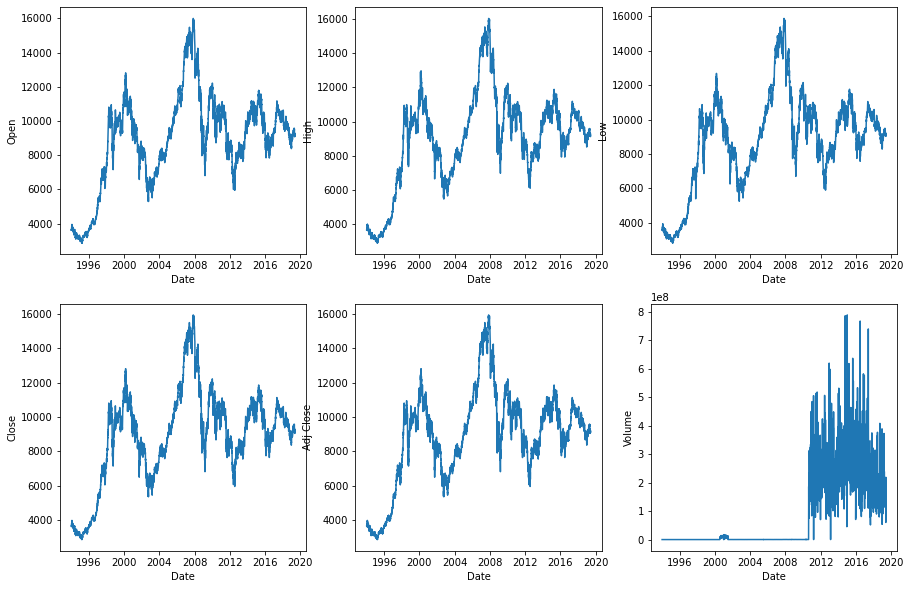

In [328]:
# plots of each feature

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))

sns.lineplot(x=df.index, y='Open', data=df, ax=axs[0,0])
sns.lineplot(x=df.index, y='High', data=df, ax=axs[0,1])
sns.lineplot(x=df.index, y='Low', data=df, ax=axs[0,2])

sns.lineplot(x=df.index, y='Close', data=df, ax=axs[1,0])
sns.lineplot(x=df.index, y='Adj Close', data=df, ax=axs[1,1])
sns.lineplot(x=df.index, y='Volume', data=df, ax=axs[1,2])


<AxesSubplot:>

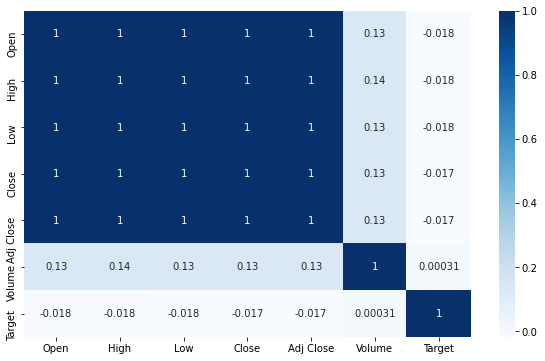

In [329]:
# correlation plot

corr = df.corr()
sns.heatmap(corr, cmap="Blues", annot=True)

In [330]:
import math
# split for train dataset

data = df.filter(['Close'])
dataset = data.values
len_train_data = math.ceil(len(dataset) * 0.8)

In [331]:
# normalization

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [332]:
# step iteration for x_train and y_train

train_data = scaled_data[0:len_train_data, :]
x_train = []
y_train = []

STEP = 3

for i in range(STEP, len(train_data)):
    x_train.append(train_data[i-STEP:i,0])
    y_train.append(train_data[i,0])
    

In [333]:
# transformation to numpy array

x_train, y_train = np.array(x_train), np.array(y_train)

In [334]:
# reshape in order to use LSTM

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(5134, 3, 1)

In [335]:
# definition of the time series model

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 3, 50)             10400     
_________________________________________________________________
lstm_33 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_32 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [336]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [337]:
model.fit(x_train, y_train, batch_size=1, epochs=25)

Epoch 1/25
5134/5134 [==============================] - 18s 2ms/step - loss: 0.0026
Epoch 2/25
5134/5134 [==============================] - 13s 2ms/step - loss: 4.0099e-04
Epoch 3/25
5134/5134 [==============================] - 13s 2ms/step - loss: 3.2600e-04
Epoch 4/25
5134/5134 [==============================] - 13s 2ms/step - loss: 2.6230e-04: 1s - l - ETA: 0s -
Epoch 5/25
5134/5134 [==============================] - 13s 3ms/step - loss: 2.3063e-04
Epoch 6/25
5134/5134 [==============================] - 13s 3ms/step - loss: 2.1555e-04
Epoch 7/25
5134/5134 [==============================] - 13s 3ms/step - loss: 2.2427e-04
Epoch 8/25
5134/5134 [==============================] - 13s 2ms/step - loss: 2.0573e-04
Epoch 9/25
5134/5134 [==============================] - 13s 3ms/step - loss: 1.9467e-04
Epoch 10/25
5134/5134 [==============================] - 13s 3ms/step - loss: 1.8871e-04
Epoch 11/25
5134/5134 [==============================] - 13s 3ms/step - loss: 2.0437e-04
Epoch 12/25
51

In [338]:
# step iteration for x_test and y_test

test_data = scaled_data[len_train_data - STEP:, :]
x_test = []
y_test = dataset[len_train_data:,:]

for i in range(STEP, len(test_data)):
    x_test.append(test_data[i-STEP:i,0])

In [339]:
x_test = np.array(x_test)

In [340]:
# reshape for LSTM

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

In [341]:
# prediction of the test dataset

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [342]:
# final root mean squared error score

rmse = np.sqrt(np.mean(predictions - y_test) **2)
rmse

10.387307439276654

<ipython-input-343-713b20fabb4d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


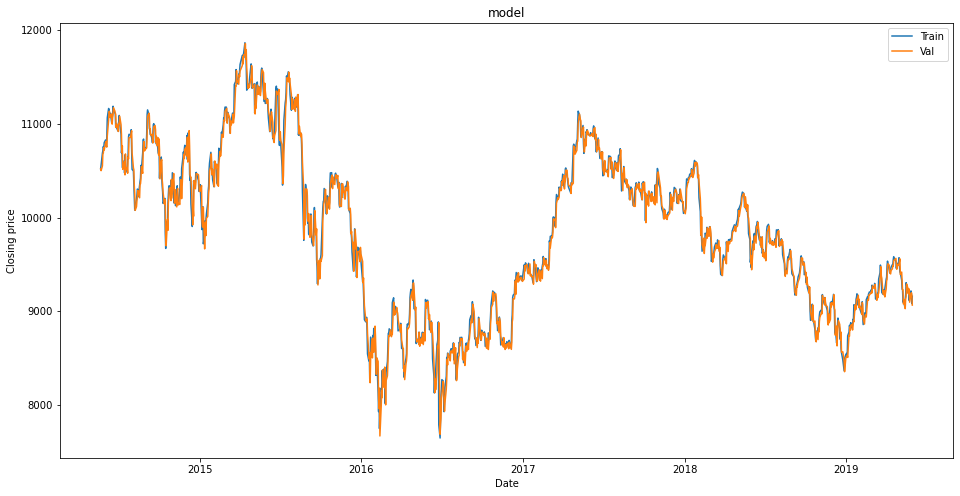

In [343]:
# plot to compare the predicted values with the actual data

train = df[:len_train_data]
valid = df[len_train_data:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('model')
plt.xlabel('Date')
plt.ylabel('Closing price')
# plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val','Predictions'])
# plt.xlim(date.toordinal(date(2016,1,1)),date.toordinal(date(2020,1,1)))
plt.show()

In [344]:
# targets and final prices for train data

test = targets[len_train_data:]
closes = closes[len_train_data:]

In [362]:
# compare the predictions with the next 3 days

predictions2=[]

for i in range(0, len(predictions)-3):
    if predictions[i] > predictions[i+3]:
        predictions2.append(0)
    else:
        predictions2.append(1)
predictions2 = predictions2 + [0,0,0]


1284

In [392]:
# FINAL DATA TEST PREDICTION AND SAVE TO CSV

df = pd.read_csv(data_directory + 'test_x.csv', parse_dates=['Date']).set_index('Date')
df.head()
aux = df.copy()

aux = aux.set_index('test_index')
aux['test_index'] = aux.index.copy()
aux['Target'] = 0
aux = aux[['Target']]
aux

df = df.dropna()

data = df.filter(['Close'])
dataset = data.values
scaled_data = scaler.fit_transform(dataset)

scaled_data = np.array(scaled_data)
scaled_data = np.reshape(scaled_data, (scaled_data.shape[0], scaled_data.shape[1], 1))

predictions = model.predict(scaled_data)
predictions = scaler.inverse_transform(predictions)

predictions2=[]

for i in range(0, len(predictions)-3):
    if predictions[i] > predictions[i+3]:
        predictions2.append(0)
    else:
        predictions2.append(1)
predictions2 = predictions2 + [0,0,0]
aux['Target'] = predictions2
aux.to_csv("predictions.csv", index = True)
aux.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 726 entries, 6557 to 7282
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Target  726 non-null    int64
dtypes: int64(1)
memory usage: 11.3 KB


In [395]:
aux.to_json('predictions.json')